# **Title**: **Named Entity Recognition (NER) with BERT for Text Classification**

### **Objective**:
**This project demonstrates the application of a pre-trained BERT model to perform Named Entity Recognition (NER) on text data, identifying entities such as locations, organizations, and persons in a given corpus.**


## **Install Required Libraries**

In [ ]:
%pip install transformers datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## **Import required libraries and dataset**

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification
from datasets import load_dataset


## **Load the pre-trained model and tokenizer for NER**

In [ ]:
# Load the pre-trained model and tokenizer for NER
model_name = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/60.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Initialize the NER pipeline**

In [ ]:
# Initialize the NER pipeline
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer)


Device set to use cpu


## **Load the dataset**

In [ ]:
# Load the CoNLL-03 dataset
dataset = load_dataset("conll2003")

# Preview a sample from the dataset
print(dataset['train'][0])


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

{'id': '0', 'tokens': ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'], 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7], 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0], 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}


## **Perform NER**

In [ ]:
# Extract text from the dataset and perform NER
num_samples_to_print = 5  # Set the number of samples to print
count = 0

for sample in dataset['test']:
    if count >= num_samples_to_print:
        break  # Stop after printing the specified number of samples

    text = " ".join(sample['tokens'])
    print(f"Text: {text}")

    # Perform Named Entity Recognition (NER) on the text
    entities = ner_pipeline(text)

    # Clean up entity tokens to merge subwords
    cleaned_entities = []
    current_entity = ''
    current_label = ''
    current_score = 0.0

    for entity in entities:
        word = entity['word']
        label = entity['entity']
        score = entity['score']

        # Skip empty or irrelevant tokens (like '-')
        if word in ['-', ''] or score < 0.5:  # Adjust the threshold score as needed
            continue

        # If it's a subword token (i.e., starting with "##"), append to the current entity
        if word.startswith('##'):
            current_entity += word[2:]
        else:
            # If there is a previous entity, save it
            if current_entity:
                cleaned_entities.append({'word': current_entity, 'label': current_label, 'score': current_score})

            # Reset for the new entity
            current_entity = word
            current_label = label
            current_score = score

    # Don't forget to add the last entity
    if current_entity:
        cleaned_entities.append({'word': current_entity, 'label': current_label, 'score': current_score})

    # Print the cleaned entities with score
    for entity in cleaned_entities:
        print(f"Entity: {entity['word']} | Label: {entity['label']} | Score: {entity['score']}")
    print("\n")

    count += 1  # Increment the count


Text: SOCCER - JAPAN GET LUCKY WIN , CHINA IN SURPRISE DEFEAT .
Entity: JAPAN | Label: I-MISC | Score: 0.9950999617576599
Entity: CHINA | Label: I-LOC | Score: 0.541292667388916


Text: Nadim Ladki
Entity: Nadim | Label: I-PER | Score: 0.9996979236602783
Entity: Ladki | Label: I-PER | Score: 0.9996190071105957


Text: AL-AIN , United Arab Emirates 1996-12-06
Entity: AL | Label: I-LOC | Score: 0.9984487295150757
Entity: AIN | Label: I-LOC | Score: 0.995570957660675
Entity: United | Label: I-LOC | Score: 0.9997562766075134
Entity: Arab | Label: I-LOC | Score: 0.9997227787971497
Entity: Emirates | Label: I-LOC | Score: 0.9998668432235718


Text: Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a Group C championship match on Friday .
Entity: Japan | Label: I-LOC | Score: 0.9998020529747009
Entity: Asian | Label: I-MISC | Score: 0.9762684106826782
Entity: Cup | Label: I-MISC | Score: 0.9974727034568787
Entity: Syria | Label: I-LOC | Score: 0.9997666478

## **save the model and tokenizer**

In [ ]:
model.save_pretrained("./ner_model")
tokenizer.save_pretrained("./ner_model")


('./ner_model/tokenizer_config.json',
 './ner_model/special_tokens_map.json',
 './ner_model/vocab.txt',
 './ner_model/added_tokens.json',
 './ner_model/tokenizer.json')

## **Sampling the dataset**

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load the NER model (Hugging Face's pipeline for NER)
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Initialize a list to store the entity types
entity_labels = []

# Sample the first 100 samples or another subset of the dataset to test
sample_size = 5
subset = dataset['test'][:sample_size]
# Print a single sample from the dataset to inspect its structure
print(dataset['test'][0])


Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


{'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7], 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0], 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]}


## **Visulaizations**

Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Sample 0: {'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7], 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0], 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]}
Processing sample 0: {'id': '0', 'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.'], 'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7], 'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0], 'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]}
Entities for sample 0: [{'entity': 'I-MISC', 'score': 0.99509996, 'index': 6, 'word': 'J', 'start': 9, 'end': 10}, {'entity': 'I-MISC', 'score': 0.96844965, 'index': 7, 'word': '##AP', 'start': 10, 'end': 12}, {'entity': 'I-MISC', 'score': 0.9932603, 'index': 8, 'word': '##AN', 'start': 12, 'end': 14}, {'entity': 'I-LOC', 'score': 0.54129267, 'index': 18, 'word': 'CH', 'start': 31, 'end': 3

<ipython-input-29-5bb9abe90786>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette='viridis')


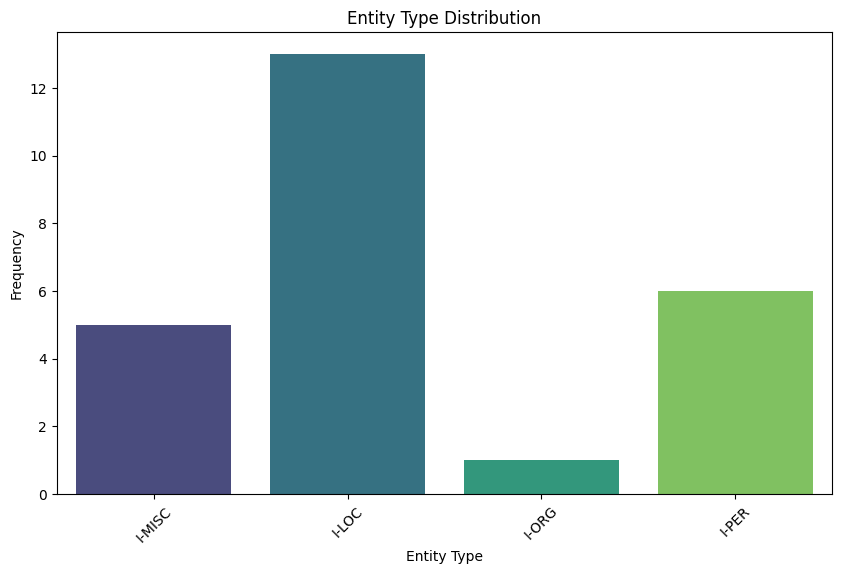

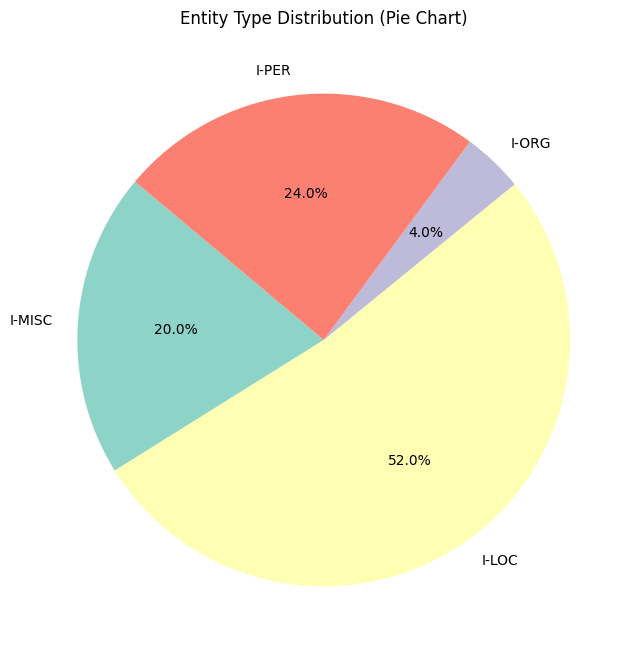

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline

# Load the NER model (Hugging Face's pipeline for NER)
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

# Initialize a list to store the entity types
entity_labels = []

# Sample the first 5 samples or another subset of the dataset to test
sample_size = 5
subset = [dataset['test'][i] for i in range(sample_size)]

# Print the first sample to inspect its structure
print("Sample 0:", dataset['test'][0])  # Check the structure of the first sample

# Process the subset and collect entity labels
for i, sample in enumerate(subset):
    print(f"Processing sample {i}: {sample}")
    # Ensure 'sample' is a dictionary and contains the 'tokens' key
    if isinstance(sample, dict) and 'tokens' in sample:
        text = " ".join(sample['tokens'])  # Join the tokens into a single string
        entities = ner_pipeline(text)  # Apply the NER pipeline to extract entities

        print(f"Entities for sample {i}: {entities}")  # Debugging: print the entities

        # Collect the labels of the recognized entities
        for entity in entities:
            label = entity['entity']
            entity_labels.append(label)
    else:
        print(f"Skipping invalid sample: {sample}")  # Debugging step to handle invalid samples

# Count the occurrences of each entity label
entity_counts = Counter(entity_labels)
print("Entity counts:", entity_counts)  # Debugging: print the entity counts

# Plot the distribution of entity labels (Bar plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), palette='viridis')
plt.title('Entity Type Distribution')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# The percentage distribution as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(entity_counts.values(), labels=entity_counts.keys(), autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set3', len(entity_counts)))
plt.title('Entity Type Distribution (Pie Chart)')
plt.show()


**Plot Explanation**

The dominant entity type in your dataset is locations (I-LOC), which makes up
more than half of the entities.

* Persons (I-PER) form nearly a quarter of the entities, which signifies a    
  substantial presence of names of individuals.

* Miscellaneous entities (I-MISC) also have a significant presence, suggesting
  diverse types of entities that don't fall into standard categories.

* Organizations (I-ORG), while present, form a smaller part of the dataset
  compared to the other categories.